In [66]:
%matplotlib inline
!pip install opencv-contrib-python==4.3.0.38

""" Forces colab to use the correct version of opencv, sets up matlab, imports
"""

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

image shape: (410, 615, 3)


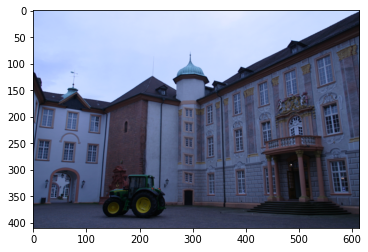

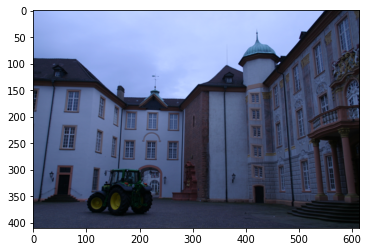

In [67]:
"""  This loads the images.  You must first upload the images to your colab
session.  Each time you start a new session, you will need to upload them again.
"""
im_left = cv2.imread('0014_2.png')
print("image shape:", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('0017_2.png')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

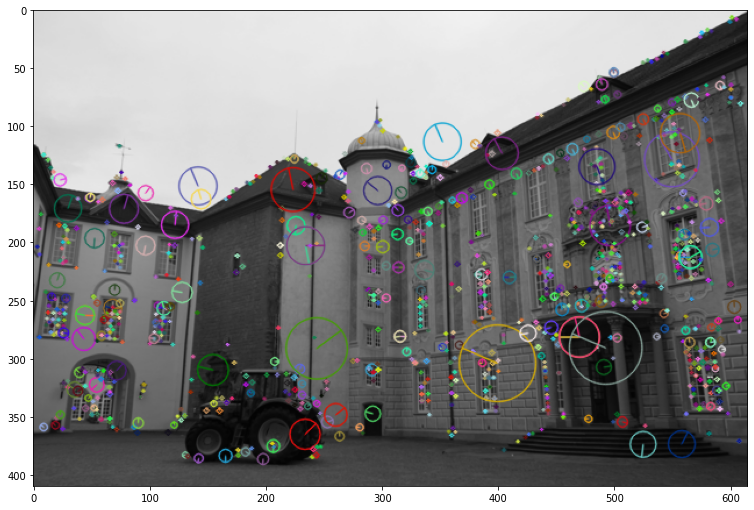

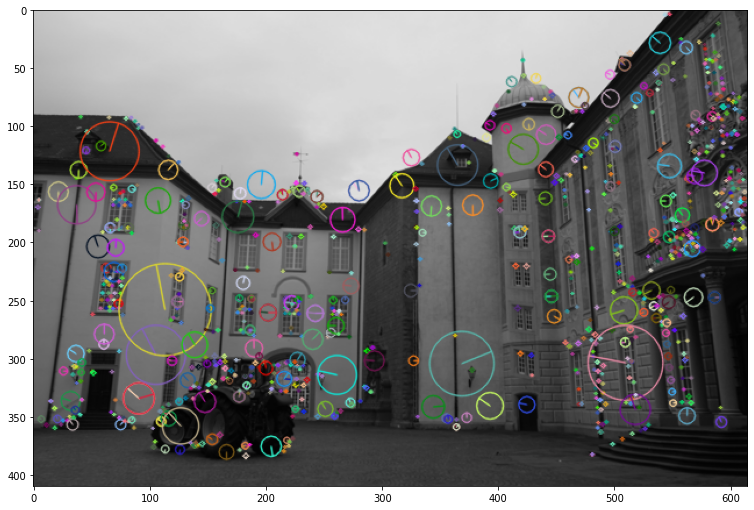

In [68]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 393


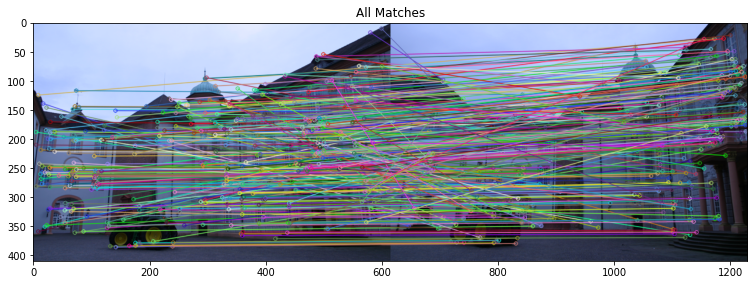

In [69]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)

In [70]:
""" Compute calibrated coordinates
"""
f = 552
u0 = 307.5
v0 = 205

K = np.array([[f, 0, u0],
              [0, f, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T


In [71]:
# print(calibrated_1.shape[1])
# print(calibrated_1.shape[0])
r=calibrated_1.shape[0]
A=np.zeros((r,9))
# print(len(calibrated_1))
a=calibrated_1.repeat(3,axis = 1 )
a1=np.array([[calibrated_1[:,0],calibrated_1[:,0],calibrated_1[:,0],calibrated_1[:,1],calibrated_1[:,1],calibrated_1[:,1],calibrated_1[:,2],calibrated_1[:,2],calibrated_1[:,2]]]).T
b=np.tile(calibrated_2,(1,3))
A=a*b
a1=a1.reshape(a1.shape[0],a1.shape[1])
# print(a1.shape)
# print(a-a1)
print((calibrated_2.T).shape)

(3, 393)


In [72]:
def correspondence_matrix(p1, p2):
    p1x, p1y = p1[:2]
    p2x, p2y = p2[:2]

    return np.array([
        p1x * p2x, p1x * p2y, p1x,
        p1y * p2x, p1y * p2y, p1y,
        p2x, p2y, np.ones(len(p1x))
    ]).T

    return np.array([
        p2x * p1x, p2x * p1y, p2x,
        p2y * p1x, p2y * p1y, p2y,
        p1x, p1y, np.ones(len(p1x))
    ]).T



In [73]:
def least_squares_estimation(X1, X2):
  """ YOUR CODE HERE
  
  """

  """ END YOUR CODE
  """
  r=X1.shape[0]
  A=np.zeros((r,9))
  # a=X1.repeat(3,axis = 1 )
  
  # a=np.array([[X1[:,0],calibrated_1[:,0],calibrated_1[:,0],calibrated_1[:,1],calibrated_1[:,1],calibrated_1[:,1],calibrated_1[:,2],calibrated_1[:,2],calibrated_1[:,2]]]).T
  # a=a.reshape(a.shape[0],a.shape[1])
  # b=np.tile(calibrated_2,(1,3))
  a = X1.repeat(3,axis=1)
  b = np.tile(X2, (1,3))
  # A=a*b

  p1x, p1y = X1[:2]
  p2x, p2y = X2[:2] 

  A= np.array([
        p1x * p2x, p1x * p2y, p1x,
        p1y * p2x, p1y * p2y, p1y,
        p2x, p2y, np.ones(len(p1x))
    ]).T


  # a2= np.array([
  #       p2x * p1x, p2x * p1y, p2x,
  #       p2y * p1x, p2y * p1y, p2y,
  #       p1x, p1y, np.ones(len(p1x))
  #   ]).T
  # A=np.concatenate(a1,a2)
  # A = correspondence_matrix(X1, X2)
  # print(A-a1)
  # print(a1)
  # print(a2)


  U,S,V =np.linalg.svd(A)
  F = V[-1].reshape(3, 3)

  
  
  U, S, V = np.linalg.svd(F)
  S[-1] = 0
  S=[1,1,0]
  F = np.dot(U, np.dot(np.diag(S), V))
  

  

  

  return F.T

E_least = least_squares_estimation(calibrated_1.T, calibrated_2.T)
print("E least", E_least)#(-E_least/E_least[0][1]))
print(calibrated_1.shape)
# fgt, mask = cv2.findFundamentalMat(calibrated_1,calibrated_2,method=cv2.FM_8POINT)
# print(fgt)

E least [[ 0.03483464  0.19532636  0.00230723]
 [ 0.12138735  0.96929545 -0.08251168]
 [-0.4816593  -0.00994682 -0.87604651]]
(393, 3)


In [38]:
import cv2 

E_ransac [[-0.00525584  0.07785024 -0.00945129]
 [-0.51976974 -0.01945897  0.85405708]
 [ 0.11256785 -0.98951664  0.04533187]]
Num inliers (180,)


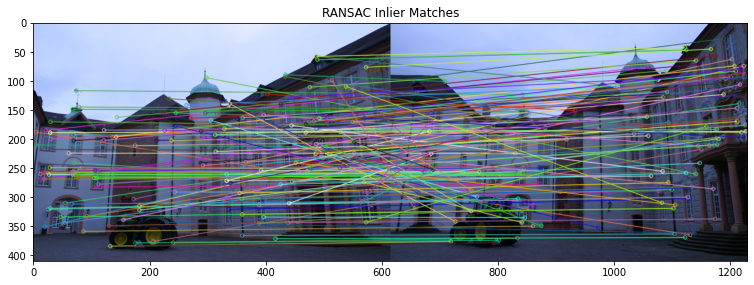

In [145]:

def ransac_estimator(X1, X2):
  num_iterations = 20000
  sample_size = 8

  eps = 10**-4

  best_num_inliers = -1

  maxInlinersYet  =  0
  best_inliers = None
  best_E = None

  for _ in range(num_iterations):
    permuted_indices = np.random.permutation(np.arange(X1.shape[0]))
    sample_indices = permuted_indices[:sample_size]
    test_indices = permuted_indices[sample_size:]
    # print(test_indices.shape)
    T1=X1[test_indices]
    T2=X2[test_indices]
    # print(sample_indices.shape)
    F = least_squares_estimation(X1[sample_indices].T,X2[sample_indices].T)

    
    f1 = np.dot(F,T1.T)
    
    F_t = np.matmul(F.T,T2.T)
    f_t = np.dot(F.T, T2.T)
    # print(F_t-f_t)
    

    dist1= np.square(T2@np.dot(F,T1.T))
    dist1 = np.diag(dist1)

    dist2= np.square(T1@np.dot(F.T, T2.T))
    dist2 = np.diag(dist2)

    res1 = np.abs(dist1) / (f1[0]**2+f1[1]**2)
    res2 = np.abs(dist2) / (f_t[0]**2+f_t[1]**2)
    res=res1+res2
    inliers=np.where(res<eps)
    inliers = inliers[0]

   


   

    if inliers.shape[0] > best_num_inliers:
      best_num_inliers = inliers.shape[0]
      best_E = F
      best_inliers=inliers
    #   print(best_inliers)
    
    





    
    
    
    
    
    

   
    

    
    #   print(best_inliers)


  return best_E, best_inliers
E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
# E_ransac,inliers =cv2.findFundamentalMat(calibrated_1, calibrated_2,cv2.RANSAC)
print("E_ransac", E_ransac)
print("Num inliers", inliers.shape)
# print(inliers)
inlier_matches = [matches[i] for i in inliers]
# print(inlier_matches)

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

In [146]:
def plot_lines(lines, h, w):
  """ Utility function to plot lines
  """

  for i in range(lines.shape[1]):
    if abs(lines[0, i] / lines[1, i]) < 1:
      y0 = -lines[2, i] / lines[1, i]
      yw = y0 - w * lines[0, i] / lines[1, i]
      plt.plot([0, w], [y0, yw])
    else:
      x0 = -lines[2, i] / lines[0, i]
      xh = x0 - h * lines[1, i] / lines[0, i]
      plt.plot([x0, xh], [0, h])

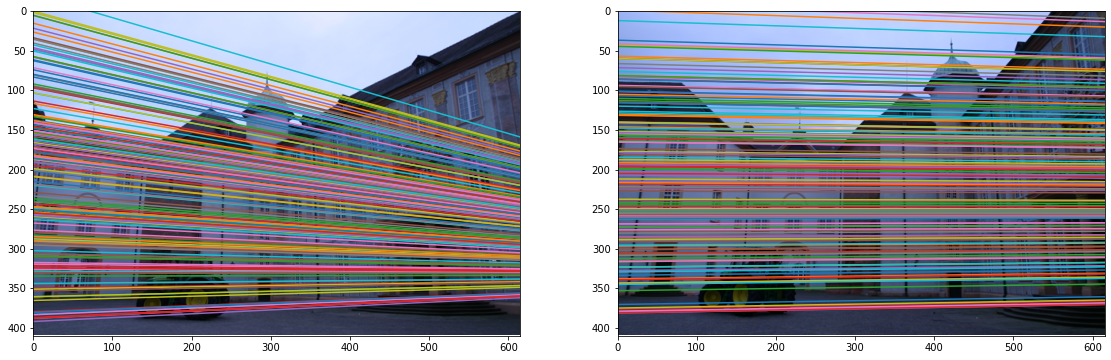

In [147]:
def plot_epipolar_lines(image1, image2, uncalibrated_1, uncalibrated_2, E, K):
  """ Plots the epipolar lines on the images
  """

  """ YOUR CODE HERE
  """

  """ END YOUR CODE
  """
  k_t = np.linalg.inv(K).T
  k_n = np.linalg.inv(K)

  epipolar_lines_in_1 = (k_t @ (E.T@k_n))@uncalibrated_2
  epipolar_lines_in_2 = (k_t @ (E@k_n))@ uncalibrated_1


  
 
  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plot_lines(epipolar_lines_in_1, image1.shape[0], image1.shape[1])

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plot_lines(epipolar_lines_in_2, image2.shape[0], image2.shape[1])


uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [148]:
def pose_canidates_from_E(E):
  transform_canidates = []
  """ YOUR CODE HERE
  """
  # print(E)
  U, S, V = np.linalg.svd(E)
  if np.linalg.det(np.dot(U, V)) < 0:
        V = -V

  W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
  canidate = {}
  canidate['T'] = U[:, 2].T
  canidate['R'] = np.dot(U, np.dot(W, V)).T
  
  canidate2 = {}
  canidate2['T'] = -U[:, 2].T
  canidate2['R'] = np.dot(U, np.dot(W, V)).T
  
  canidate3 = {}
  canidate3['T'] = U[:, 2].T
  canidate3['R'] = np.dot(U, np.dot(W.T, V)).T
  
  canidate4 = {}
  canidate4['T'] = -U[:, 2].T
  canidate4['R'] = np.dot(U, np.dot(W.T, V)).T

  transform_canidates.append(canidate)
  transform_canidates.append(canidate2)
  transform_canidates.append(canidate3)
  transform_canidates.append(canidate4)




  
  # transform_candidates =np.array( [np.vstack((np.dot(U, np.dot(W, V)).T, U[:, 2])).T,
  #         np.vstack((np.dot(U, np.dot(W, V)).T, -U[:, 2])).T,
  #         np.vstack((np.dot(U, np.dot(W.T, V)).T, U[:, 2])).T,
  #         np.vstack((np.dot(U, np.dot(W.T, V)).T, -U[:, 2])).T])

  # transform_canidates.append(canidate)

  """ END YOUR CODE
  """
  # print (np.dot(U, np.dot(W, V)).T, U[:, 2].T)
  return transform_canidates


transform_canidates = pose_canidates_from_E(E_ransac)
print("transform_canidates", transform_canidates)

transform_canidates [{'T': array([0.99690641, 0.00687627, 0.07829641]), 'R': array([[ 0.80275142,  0.11845423,  0.58443027],
       [ 0.12498212, -0.99172522,  0.02933537],
       [ 0.58306914,  0.04949432, -0.81091349]])}, {'T': array([-0.99690641, -0.00687627, -0.07829641]), 'R': array([[ 0.80275142,  0.11845423,  0.58443027],
       [ 0.12498212, -0.99172522,  0.02933537],
       [ 0.58306914,  0.04949432, -0.81091349]])}, {'T': array([0.99690641, 0.00687627, 0.07829641]), 'R': array([[ 0.88569172, -0.10680801, -0.45182101],
       [ 0.11442088,  0.99337653, -0.01053281],
       [ 0.44995337, -0.04236894,  0.89204643]])}, {'T': array([-0.99690641, -0.00687627, -0.07829641]), 'R': array([[ 0.88569172, -0.10680801, -0.45182101],
       [ 0.11442088,  0.99337653, -0.01053281],
       [ 0.44995337, -0.04236894,  0.89204643]])}]


In [127]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')

In [133]:
def reconstruct3D(transform_canidates, calibrated_1, calibrated_2):
  """This functions selects (T,R) among the 4 candidates transform_candidates
  such that all triangulated points are in front of both cameras.
  """

  best_num_front = -1
  best_canidate = None
  best_lambdas = None
  for canidate in transform_canidates:
    R = canidate['R']
    T = canidate['T']
    for i in range(len(calibrated_1)):
      x1 = calibrated_1[i].T
      x2 = calibrated_2[i]
      print(x2.shape,x1.shape)
      lambdas[:,i] = np.linalg.pinv(x2, -R@x1)@T

    lambdas = np.zeros((2, calibrated_1.shape[0]))
    """ YOUR CODE HERE
    """

    """ END YOUR CODE
    """
    num_front = np.sum(np.logical_and(lambdas[0]>0, lambdas[1]>0))

    if num_front > best_num_front:
      best_num_front = num_front
      best_canidate = canidate
      best_lambdas = lambdas
      print("best", num_front, best_lambdas[0].shape)
    else:
      print("not best", num_front)


  P1 = best_lambdas[1].reshape(-1, 1) * calibrated_1
  P2 = best_lambdas[0].reshape(-1, 1) * calibrated_2
  T = best_canidate['T']
  R = best_canidate['R']
  return P1, P2, T, R


P1, P2, T, R = reconstruct3D(transform_canidates, calibrated_1, calibrated_2)
# print(transform_canidates.shape)

plot_reconstruction(P1, P2, T, R)

(3,) (3,)


LinAlgError: ignored

In [ ]:
def show_reprojections(image1, image2, uncalibrated_1, uncalibrated_2, P1, P2, K, T, R):

  """ YOUR CODE HERE
  """

  """ END YOUR CODE
  """


  plt.figure(figsize=(6.4*3, 4.8*3))
  ax = plt.subplot(1, 2, 1)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image1[:, :, ::-1])
  plt.plot(P2proj[:, 0] / P2proj[:, 2],
           P2proj[:, 1] / P2proj[:, 2], 'bs')
  plt.plot(uncalibrated_1[0, :], uncalibrated_1[1, :], 'ro')

  ax = plt.subplot(1, 2, 2)
  ax.set_xlim([0, image1.shape[1]])
  ax.set_ylim([image1.shape[0], 0])
  plt.imshow(image2[:, :, ::-1])
  plt.plot(P1proj[:, 0] / P1proj[:, 2],
           P1proj[:, 1] / P1proj[:, 2], 'bs')
  plt.plot(uncalibrated_2[0, :], uncalibrated_2[1, :], 'ro')

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)